https://colab.research.google.com/github/MicPie/DepthFirstLearning/blob/master/InfoGAN/DCGAN_MNIST_v5.ipynb#scrollTo=LoHjTjxcESKZ
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/5f81194dd43910d586578638f83205a3/dcgan_faces_tutorial.ipynb#scrollTo=JBS91Rh4CSMy

In [1]:
import torch
import torchvision

In [ ]:
dataset_train = torchvision.datasets.MNIST(root="./", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataset_test = torchvision.datasets.MNIST(root="./", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=256, shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module): # https://github.com/lyeoni/pytorch-mnist-VAE
    def __init__(self):
        super(VAE, self).__init__()

        # prob. encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, 128)
        self.fc_log_var = nn.Linear(256, 128)

        # prob.decoder
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_log_var(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [11]:
device = "cuda"
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(),lr=0.001)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [12]:
from statistics import mean
from tqdm import tqdm
# Training Loop
train_losses = []
test_losses = []
num_epochs = 20
print("Starting Training Loop...")
def test():
    temp_losses=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader, 0)):
            real_images = data[0].reshape(-1,784).to(device)
            recon_x, mu, logvar = vae.forward(real_images)
            loss = loss_function(recon_x, real_images, mu, logvar)
            temp_losses.append(loss.item())
    return mean(temp_losses)


for epoch in range(num_epochs):
    # For each batch in the dataloader
    temp_losses = []
    for i, data in enumerate(train_dataloader, 0):
        vae.zero_grad()
        real_images = data[0].reshape(-1,784).to(device)
        recon_x, mu, logvar = vae.forward(real_images)
        loss = loss_function(recon_x, real_images, mu, logvar)
        loss.backward()
        optimizer.step()
        temp_losses.append(loss.item())
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     loss.item()))

        if i % 200==0:
            train_losses.append(mean(temp_losses))
            test_losses.append(test())


Starting Training Loop...
[0/20][0/235]	Loss: 139383.3438


40it [00:01, 28.33it/s]


[0/20][50/235]	Loss: 51775.6953
[0/20][100/235]	Loss: 51338.4688
[0/20][150/235]	Loss: 48045.1992
[0/20][200/235]	Loss: 47542.6641


40it [00:01, 31.12it/s]


[1/20][0/235]	Loss: 45342.3633


40it [00:01, 31.12it/s]


[1/20][50/235]	Loss: 41577.6562
[1/20][100/235]	Loss: 41078.9297
[1/20][150/235]	Loss: 39252.8516
[1/20][200/235]	Loss: 38254.5938


40it [00:01, 31.34it/s]


[2/20][0/235]	Loss: 37640.1250


40it [00:01, 30.33it/s]


[2/20][50/235]	Loss: 36830.3984
[2/20][100/235]	Loss: 34855.4180
[2/20][150/235]	Loss: 34219.5391
[2/20][200/235]	Loss: 33387.2109


40it [00:01, 30.20it/s]


[3/20][0/235]	Loss: 32818.6055


40it [00:01, 31.52it/s]


[3/20][50/235]	Loss: 31845.1582
[3/20][100/235]	Loss: 31670.1992
[3/20][150/235]	Loss: 31550.7812
[3/20][200/235]	Loss: 32521.7930


40it [00:01, 31.38it/s]


[4/20][0/235]	Loss: 31269.7070


40it [00:01, 29.91it/s]


[4/20][50/235]	Loss: 29890.5723
[4/20][100/235]	Loss: 30796.6602
[4/20][150/235]	Loss: 30617.3613
[4/20][200/235]	Loss: 30156.3242


40it [00:01, 30.08it/s]


[5/20][0/235]	Loss: 30314.2949


40it [00:01, 31.40it/s]


[5/20][50/235]	Loss: 29895.7344
[5/20][100/235]	Loss: 29724.3438
[5/20][150/235]	Loss: 30442.3652
[5/20][200/235]	Loss: 30783.0938


40it [00:01, 31.69it/s]


[6/20][0/235]	Loss: 29330.5840


40it [00:01, 31.71it/s]


[6/20][50/235]	Loss: 28454.3066
[6/20][100/235]	Loss: 29700.8047
[6/20][150/235]	Loss: 28661.7949
[6/20][200/235]	Loss: 28820.1875


40it [00:01, 31.65it/s]


[7/20][0/235]	Loss: 29319.1875


40it [00:01, 31.74it/s]


[7/20][50/235]	Loss: 29402.0664
[7/20][100/235]	Loss: 27774.2285
[7/20][150/235]	Loss: 28613.6953
[7/20][200/235]	Loss: 29263.0625


40it [00:01, 29.56it/s]


[8/20][0/235]	Loss: 28524.9355


40it [00:01, 28.79it/s]


[8/20][50/235]	Loss: 28136.9375
[8/20][100/235]	Loss: 28496.6953
[8/20][150/235]	Loss: 28107.0957
[8/20][200/235]	Loss: 28146.0664


40it [00:01, 24.11it/s]


[9/20][0/235]	Loss: 27821.7402


40it [00:01, 31.19it/s]


[9/20][50/235]	Loss: 28584.8164
[9/20][100/235]	Loss: 28088.0742
[9/20][150/235]	Loss: 28043.0977
[9/20][200/235]	Loss: 28655.6836


40it [00:01, 22.82it/s]


[10/20][0/235]	Loss: 27888.6328


40it [00:01, 30.80it/s]


[10/20][50/235]	Loss: 26806.9277
[10/20][100/235]	Loss: 27260.7070
[10/20][150/235]	Loss: 27454.4336
[10/20][200/235]	Loss: 27531.2910


40it [00:01, 26.30it/s]


[11/20][0/235]	Loss: 28045.9258


40it [00:01, 31.16it/s]


[11/20][50/235]	Loss: 27854.7891
[11/20][100/235]	Loss: 27416.0723
[11/20][150/235]	Loss: 26989.7637
[11/20][200/235]	Loss: 27179.0664


40it [00:01, 31.08it/s]


[12/20][0/235]	Loss: 26602.1836


40it [00:01, 24.21it/s]


[12/20][50/235]	Loss: 26799.3203
[12/20][100/235]	Loss: 27296.8965
[12/20][150/235]	Loss: 28078.2812
[12/20][200/235]	Loss: 26666.2324


40it [00:01, 31.39it/s]


[13/20][0/235]	Loss: 27969.6211


40it [00:01, 22.64it/s]


[13/20][50/235]	Loss: 27199.8750
[13/20][100/235]	Loss: 26017.3496
[13/20][150/235]	Loss: 27079.5352
[13/20][200/235]	Loss: 26746.1680


40it [00:01, 31.85it/s]


[14/20][0/235]	Loss: 26805.5859


40it [00:01, 27.74it/s]


[14/20][50/235]	Loss: 27492.9648
[14/20][100/235]	Loss: 26434.8340
[14/20][150/235]	Loss: 26349.2891
[14/20][200/235]	Loss: 26852.4863


40it [00:01, 31.70it/s]


[15/20][0/235]	Loss: 26386.2266


40it [00:01, 30.82it/s]


[15/20][50/235]	Loss: 26094.7422
[15/20][100/235]	Loss: 25760.3105
[15/20][150/235]	Loss: 25785.1895
[15/20][200/235]	Loss: 27025.8164


40it [00:01, 30.60it/s]


[16/20][0/235]	Loss: 25488.5273


40it [00:01, 27.96it/s]


[16/20][50/235]	Loss: 26080.5762
[16/20][100/235]	Loss: 26645.5605
[16/20][150/235]	Loss: 26290.3125
[16/20][200/235]	Loss: 26478.2188


40it [00:01, 31.19it/s]


[17/20][0/235]	Loss: 26617.5664


40it [00:01, 32.24it/s]


[17/20][50/235]	Loss: 26143.8125
[17/20][100/235]	Loss: 26163.9805
[17/20][150/235]	Loss: 26563.7539
[17/20][200/235]	Loss: 27312.5039


40it [00:01, 31.56it/s]


[18/20][0/235]	Loss: 26394.5312


40it [00:01, 30.96it/s]


[18/20][50/235]	Loss: 27168.4414
[18/20][100/235]	Loss: 26431.2305
[18/20][150/235]	Loss: 26236.7539
[18/20][200/235]	Loss: 26538.1953


40it [00:01, 30.67it/s]


[19/20][0/235]	Loss: 26259.6289


40it [00:01, 29.12it/s]


[19/20][50/235]	Loss: 26550.0273
[19/20][100/235]	Loss: 26974.0742
[19/20][150/235]	Loss: 26425.6152
[19/20][200/235]	Loss: 25801.4453


40it [00:01, 31.24it/s]


In [16]:
import torchvision
fixed_noise = torch.randn(64, 128, device=device)
with torch.no_grad():
    img = vae.decoder(fixed_noise).reshape(64,1,28,28)
    grid = torchvision.utils.make_grid(img)


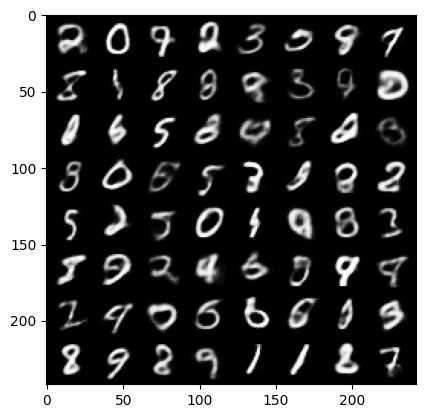

In [17]:
import matplotlib.pyplot as plt
plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

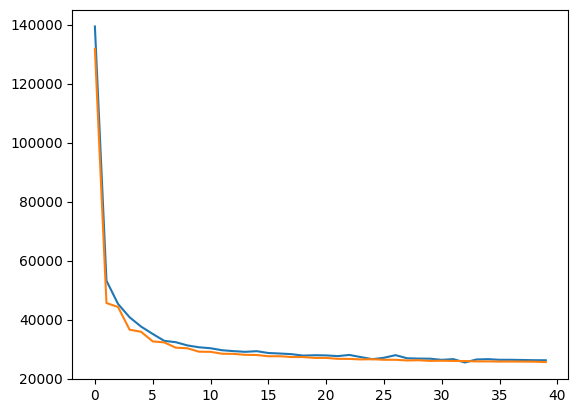

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()